# Plant-based food products - what's behind the hype?
by Agnes Lei

<br>

# Introduction

Plant-based diets have been a trend in recent years and the number of plant-based food products have been increasing in the market. For some food products like flour, coconut water, spaghetti, which are quite obviously plant-based, a plant-based label on the packages seem more like a marketing strategy than an informative label. In this project, we would like to use the data from  FoodData Central (FDC) to get a better understanding of the popularity and nutritients of food products which are described as **plant-based** by answering the following questions:
- What are the top 10 food categories which have the most plant-based products?
- What are the top 10 ingredients in the top 10 categories?
- What are the top ingredients all plant-based items?
- What are the amount of energy, protein, sugar, fiber and fat per serving for each food category?

The data is extracted via API and loaded to MongoDB. Here's a class diagram of the collection:

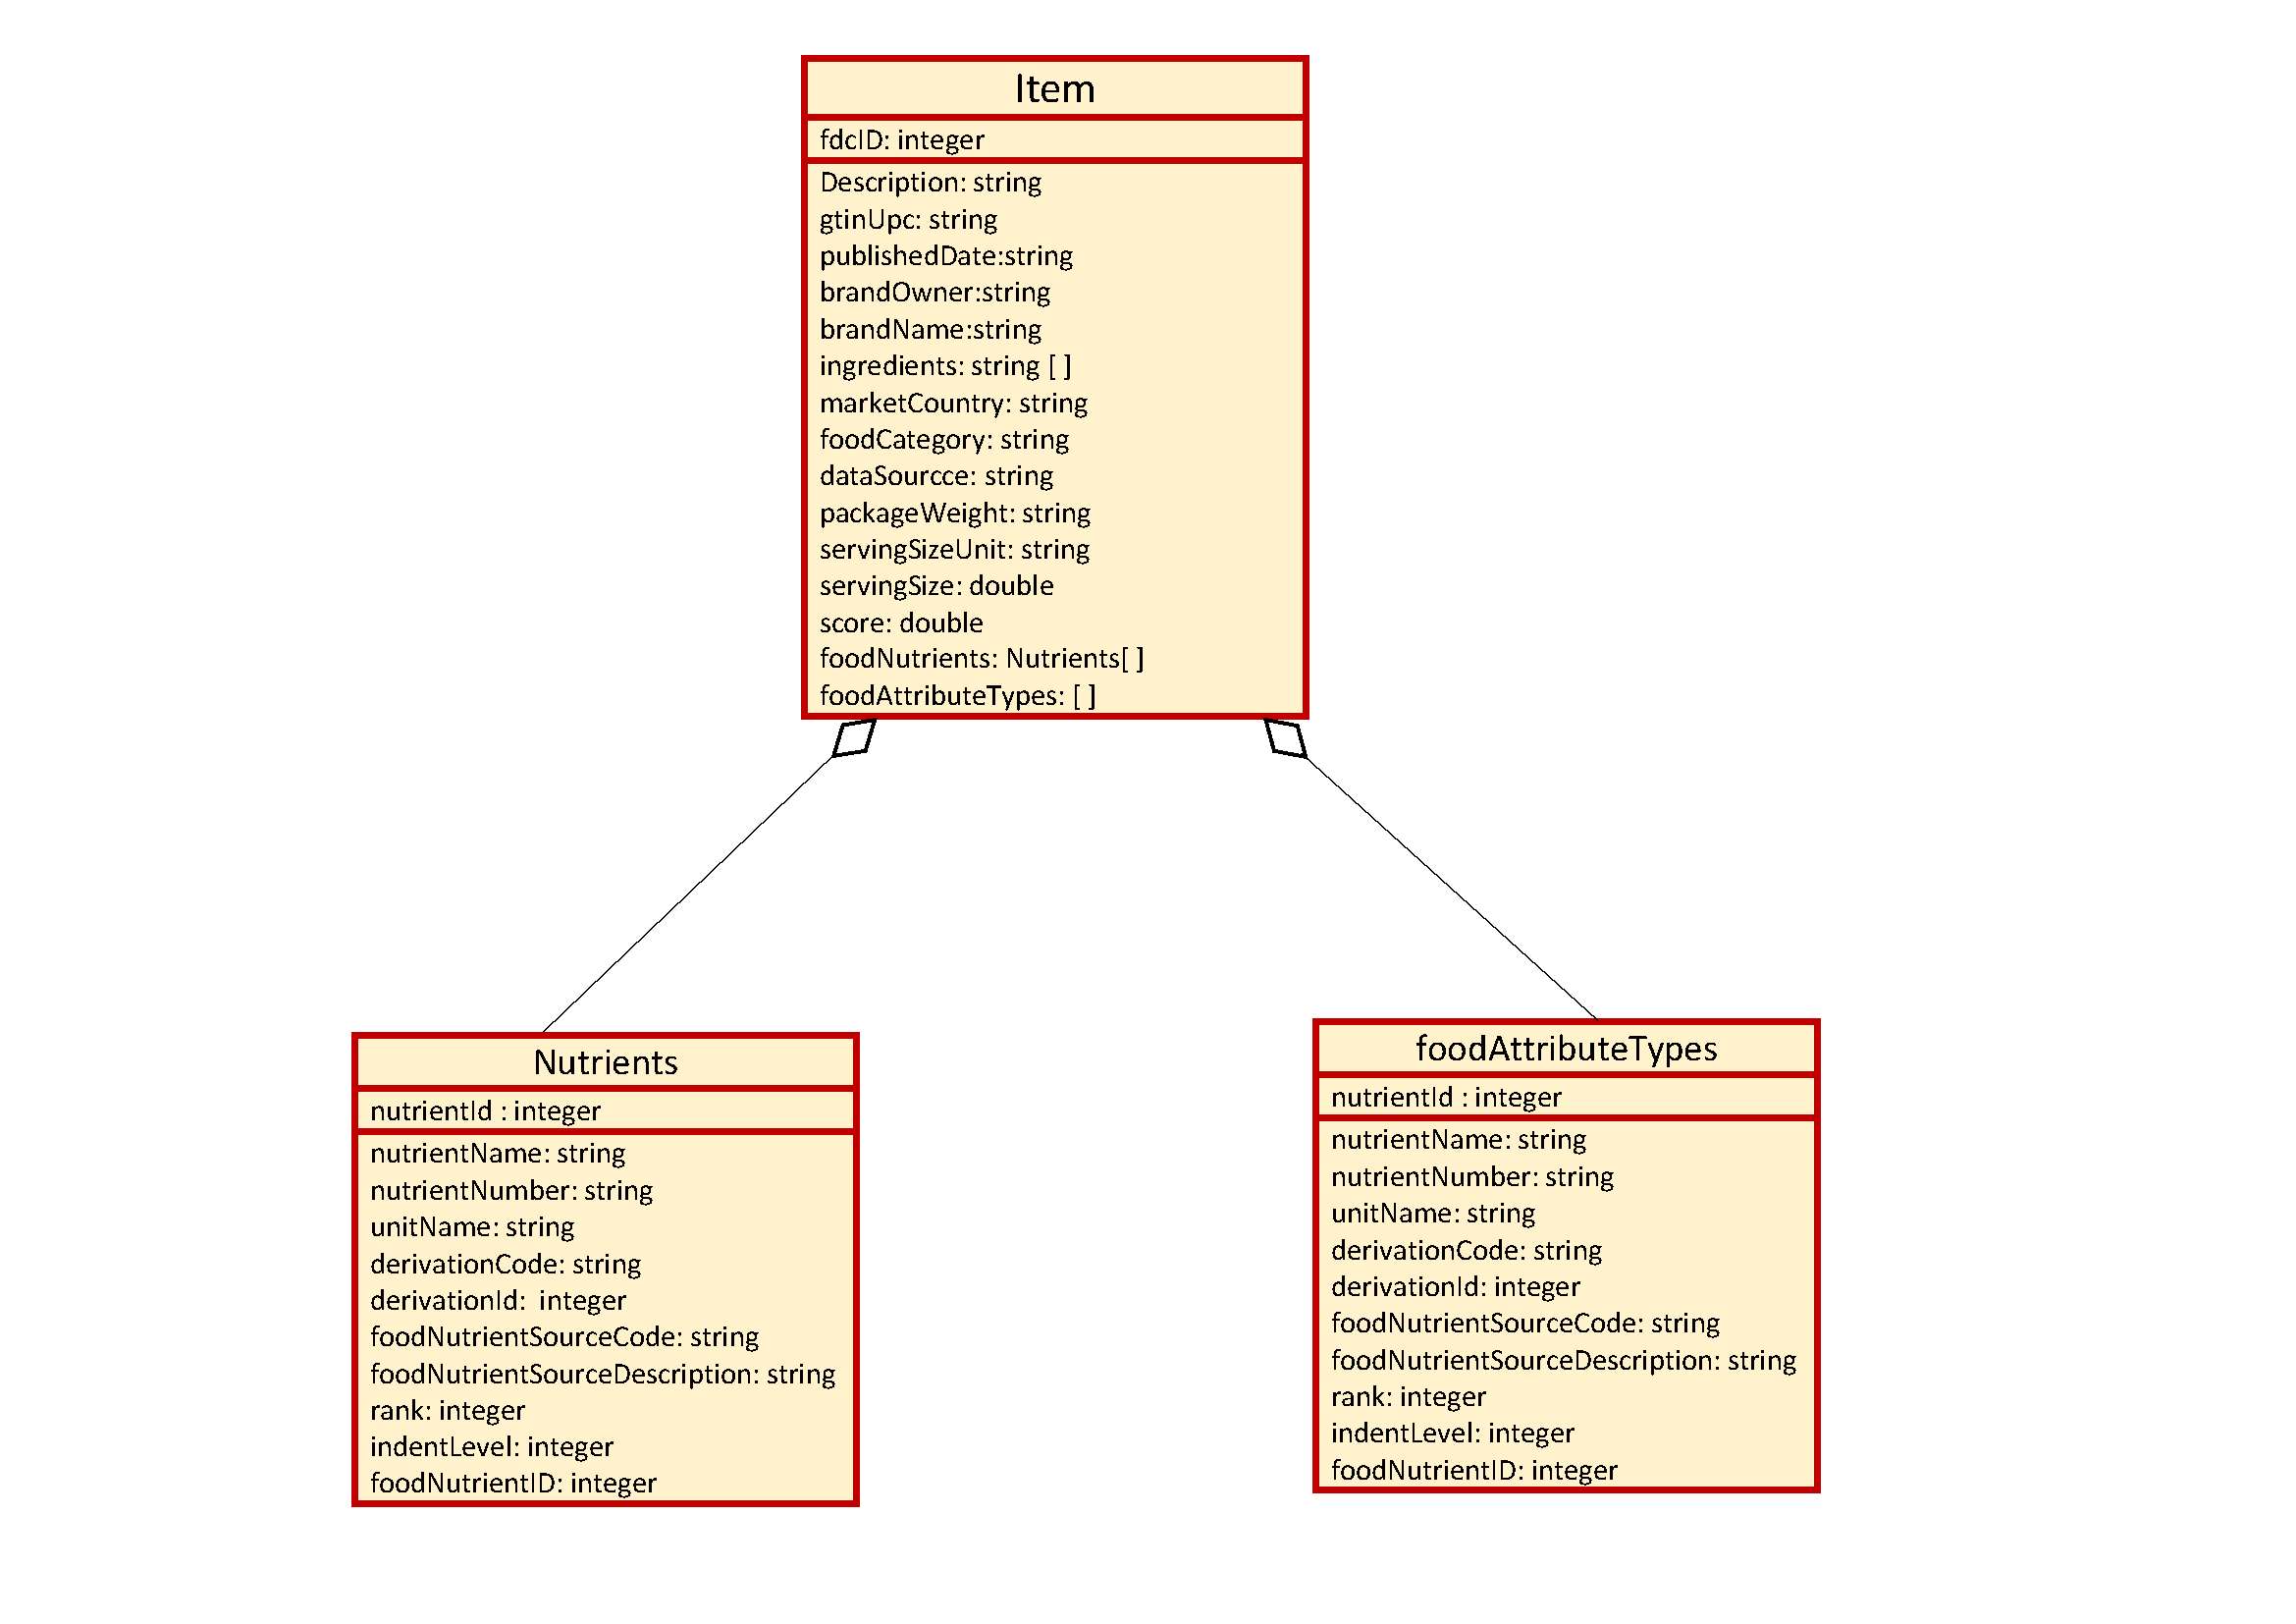

In [57]:
from IPython.display import Image
Image(filename='Class Diagram.png', width = 600, height = 500)

**Below are all the packages used in this project**

In [2]:
import sqlite3
import requests
import string
from pprint import pprint
import pymongo
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

## Extract Data

<br>

The API used is **The FoodData Central API**. It provides REST access to FoodData Central (FDC) with two endpoints: the Food Search endpoint, which returns foods that match desired search criteria, and the Food Details endpoint, which returns details on a particular food. 

In [3]:
#here's the api key to access the data
api_key = "VEHZf6iD3VcOEYRTbJeKmXRusZEQDZbsQujFZ5jd"

#query for plant-based food products
query = "PLANT%20BASED"

#initialize an empty list for data
data = []

#url for api
url = 'https://api.nal.usda.gov/fdc/v1/foods/search?api_key={}'\
      '&requireAllWords=true&query={}&pageSize=2000'.format(api_key, query)
r = requests.get(url)

#extract the information needed and append it to data
food = r.json()['foods']
data += food

#covert the data to an dataframe
df = pd.DataFrame(data)

In [4]:
df.shape

(2000, 30)

2000 plant-based food items are fetched for the analysis.

##  Load Data

In [5]:
# Setup connection
client = pymongo.MongoClient("mongodb+srv://agnes_db:"\
                             "Bigdata22@bdl03.ez66j.mongodb.net")

In [6]:
# create database "plant_based_food_items" 
db = client['plant_based_food_items']

In [7]:
# Set collection "items" -> col
col = db.items

In [8]:
# insert data to the database
for doc in data:
    col.insert_one(doc)

In [9]:
# Count document in collection
col.count_documents({})

2000

In [10]:
#check whether the database is created
client.list_database_names()

['db_test',
 'plant_based_food_items',
 'sample_airbnb',
 'sample_analytics',
 'sample_geospatial',
 'sample_mflix',
 'sample_restaurants',
 'sample_supplies',
 'sample_training',
 'sample_weatherdata',
 'test',
 'test_db',
 'admin',
 'local']

## Transform

**The field *ingredients* is one string containing all ingredients. Let's covert that to an array to facilitate analysis.**

In [11]:
#inspect data
db.items.find_one()['ingredients']

'CORNSTARCH, COCONUT OIL, INACTIVE YEAST, RICE, CALCIUM CITRATE, NATURAL VEGAN FLAVORS, SEA SALT, GLYCERINE, LACTIC ACID.'

**First we create a function which turn the string to a list by :**
- spliting the string by non alphanumeric delimiter except white space, %, :
- use strip() to remove unwanted space
- adding each ingredient to a set to avoid duplicated ingredients
- turn the set to a list

In [12]:
def string_to_list(ingredients):
    li = re.split("[^a-zA-Z\d\s\%\:\.]", ingredients)
    new_li = set()
    for ingredient in li:
        if re.search('[a-zA-Z]', ingredient):
            each_ingredient = ingredient.strip()
            if each_ingredient[-1] == ".":
                each_ingredient = each_ingredient[:-1]
            new_li.add(re.sub(r'[^a-zA-Z\s]', '', each_ingredient).strip())
    return list(new_li)

<br>

**Now we iterate over the documents in the collection to update all *ingredients***

In [13]:
for doc in db.items.find():
    db.items.update_one({"fdcId": doc["fdcId"]},
                        {"$set": {"ingredients": string_to_list(doc["ingredients"])}})

In [14]:
#inspect the ingredients again
db.items.find_one()['ingredients']

['RICE',
 'INACTIVE YEAST',
 'CALCIUM CITRATE',
 'SEA SALT',
 'GLYCERINE',
 'NATURAL VEGAN FLAVORS',
 'CORNSTARCH',
 'LACTIC ACID',
 'COCONUT OIL']

**Next, let's check which fields are empty and can be dropped**

In [15]:
empty_fields = []

for field in db.items.find_one().keys(): #iterate through the fields 
    #match non empty fields 
    match = {"$match":{field: {"$exists": True, "$not": {"$size": 0}}}} 
    #count the total of non empty entries in each field
    count = {"$count": "total"} 
    cursor = db.items.aggregate([match, count])
    #look for fields which have no non empyt entries at all
    if list(cursor) == []: 
        #append to the list
        empty_fields.append(field)
    else:
        pass

empty_fields

['finalFoodInputFoods', 'foodMeasures', 'foodAttributes', 'foodVersionIds']

In [16]:
db.items.update_many({}, {"$unset": {'finalFoodInputFoods':1, 'foodMeasures':1, 
                                     'foodAttributes':1, 'foodVersionIds':1}})

In [17]:
#check whether the fields are removed
db.items.find_one().keys()

dict_keys(['_id', 'fdcId', 'description', 'lowercaseDescription', 'dataType', 'gtinUpc', 'publishedDate', 'brandOwner', 'brandName', 'ingredients', 'marketCountry', 'foodCategory', 'modifiedDate', 'dataSource', 'packageWeight', 'servingSizeUnit', 'servingSize', 'allHighlightFields', 'score', 'foodNutrients', 'foodAttributeTypes'])

**Next, we check if there are any duplicates**

In [ ]:
#Check duplicates

group = {"$group" : 
         { "_id": "$gtinUpc", "dups": 
          {"$push": "$_id"}, "count": { "$sum": 1 } 
         } }
match = {"$match": {"count" : {"$gt": 1} }}
sort = {"$sort": {"count" : -1}}

pipeline = [group, match, sort]
pprint(list(db.items.aggregate(pipeline)))

## Data Analysis

<br>

#### 1) What are the top 10 food categories which have the most plant-based products?

In [18]:
#group items by category and count the sum
group = {"$group" : {"_id":"$foodCategory", "total":{"$sum":1}}}
#reverse sorting 
sort = {"$sort": {"total": -1}}
#get top 10
limit = {"$limit": 10}

pipeline = [group, sort, limit]

food_cat = pd.DataFrame(db.items.aggregate(pipeline))

food_cat.rename(columns={"_id": "foodCategory"}, 
                    inplace=True)

food_cat

,foodCategory,total
0,Plant Based Milk,530
1,Plant Based Water,320
2,Other Meats,121
3,"Snack, Energy & Granola Bars",91
4,Vegetarian Frozen Meats,75
5,Cheese,70
6,"Energy, Protein & Muscle Recovery Drinks",68
7,Yogurt,59
8,Other Frozen Desserts,53
9,Other Drinks,47


The second place caught me by surprise 😮 
<br>I didn't know that **plant based water** is a thing! As if normal water would contains animal ingredients🤷‍♀️

Ok, now that we know the top 10 categories, what about ...
### 2) What are the top 10 ingredients in the top 10 categories?

In [19]:
unwind = {"$unwind": '$ingredients'} #unwind the ingredients array 
group = {"$group" : {"_id":"$ingredients", "total":{"$sum":1}}} #count the number of occurance of an ingredient
sort = {"$sort": {"total":-1}} #sort the total reversely
limit = {"$limit": 10} #get top 10
project_group = {"$project": {"_id": 1,"total": 0}}

#get the top 10 categories in a list
foodCat_list = list(food_cat["foodCategory"])

#prepare an empty dict
cat_in_dict = dict()

#iterate through the top categories 
for cat in foodCat_list:
  
    #match each of the top 10 categories
    match = {"$match": {"foodCategory": {"$eq": cat}}}
    
    pipeline = [unwind, match, group, sort, limit,project_group]
    
    #get a list of ingredients
    in_list = sorted(list(pd.DataFrame(db.items.aggregate(pipeline))["_id"]))
    
    #create a dict of the top 10 ingredients for each category
    cat_in_dict[cat] = in_list

In [20]:
#covert the result to a dataframe
top_in = pd.DataFrame.from_dict(cat_in_dict)

top_in.style.hide_index()

Plant Based Milk,Plant Based Water,Other Meats,"Snack, Energy & Granola Bars",Vegetarian Frozen Meats,Cheese,"Energy, Protein & Muscle Recovery Drinks",Yogurt,Other Frozen Desserts,Other Drinks
ALMONDS,ASCORBIC ACID,CANOLA OIL,ALMONDS,CANOLA OIL,CITRIC ACID,GELLAN GUM,CANE SUGAR,AGAVE SYRUP,FILTERED WATER
CALCIUM CARBONATE,CITRIC ACID,COLOR,CHIA SEEDS,GARLIC POWDER,COCONUT OIL,GUAR GUM,CASHEWMILK,COCONUT,GELLAN GUM
FILTERED WATER,COCONUT WATER,METHYLCELLULOSE,CHICORY ROOT FIBER,METHYLCELLULOSE,COLOR,NATURAL FLAVORS,CASHEWS,COCONUT CREAM,LIVE AND ACTIVE CULTURES
GELLAN GUM,NATURAL COCONUT WATER,NATURAL FLAVORS,NATURAL FLAVOR,NATURAL FLAVORS,FILTERED WATER,ORGANIC CANE SUGAR,COCONUT CREAM,COCONUT MILK,MONK FRUIT EXTRACT
SEA SALT,NATURAL FLAVORS,PEA PROTEIN,NATURAL FLAVORS,ONION POWDER,MONK FRUIT EXTRACT,ORGANIC STEVIA EXTRACT,FILTERED WATER,COCONUT OIL,ORGANIC FOOD STARCH
SUNFLOWER LECITHIN,ORGANIC COCONUT WATER,SALT,ORGANIC PEA PROTEIN,SALT,NATURAL FLAVOR,PEA PROTEIN,LIVE ACTIVE CULTURES,GUAR GUM,ORGANIC LOCUST BEAN GUM
VITAMIN A PALMITATE,SUGAR,SEA SALT,PEA PROTEIN,SPICES,NATURAL FLAVORS,PROTEASE,LOCUST BEAN GUM,SALT,ORGANIC PEA PROTEIN
VITAMIN B,VITAMIN C,SPICES,SEA SALT,SUGAR,SALT,SEA SALT,NATURAL FLAVOR,SUGAR,ORGANIC SUGAR
VITAMIN D,WATER,WATER,SUGAR,WATER,SEA SALT,WATER,PECTIN,VANILLA EXTRACT,TAPIOCA
WATER,YOUNG COCONUT PULP,YEAST EXTRACT,SUNFLOWER LECITHIN,YEAST EXTRACT,WATER,XANTHAN GUM,WATER,WATER,WATER


**Let's visualize the resutls in a wordcloud**

In [35]:
ingredients = []

for i in list(top_in):
    for j in top_in[i].tolist():
        ingredients.append(j)

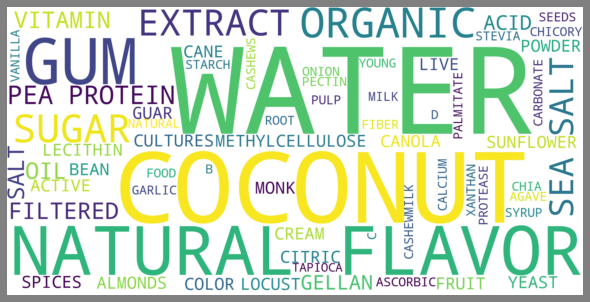

In [37]:
wordcloud = WordCloud(width = 2000,
                      height = 1000,
                      background_color = 'white',
                      stopwords = STOPWORDS).generate(" ".join(ingredients))
fig = plt.figure(
    figsize = (8,8),
    facecolor = 'grey',
    edgecolor = 'red')
    
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

No surprise, water is quite commonly used as an ingredient. I guess you can't make plant-based water without water, right? Coconut, natural flavor, sugar ... these all make sense. But why is **gum** used as an ingredient? Are there plant-based chewing gums as well? <br> Ohh ok, Google says that gums are commonly added to foods as a thickener or stabilizer... I didn't know that!

Now that I have seen the top ingredients in the top food categories, I want see the bigger big picture...
### 3) What are the top ingredients all items?

In [41]:
#get the ingredients of each item as a dictionary and put them in a list
li = list(db.items.aggregate([{"$project": {  "ingredients": 1, "_id": 0}}]))

#unwind the dictionaries and get all the values
li_1 = [list(i.values()) for i in li]

#combine all the lists into one big list
all_ingredients = [ingredient for sublist in li_1 for ingredients in sublist for ingredient in ingredients]

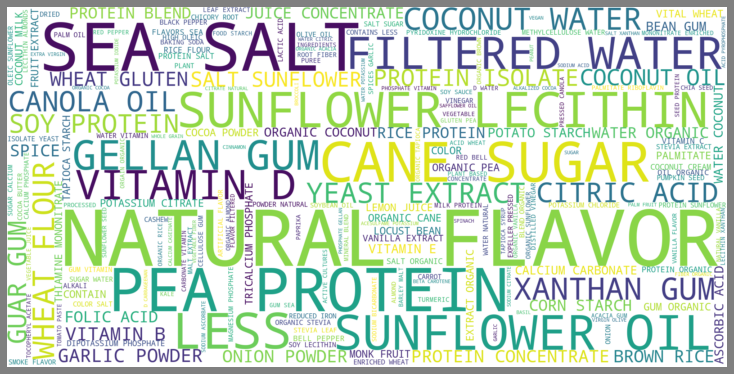

In [44]:
wordcloud = WordCloud(width = 2000,
                      height = 1000,
                      background_color = 'white',
                      stopwords = STOPWORDS).generate(" ".join(all_ingredients))

fig = plt.figure(figsize = (10,10),facecolor = 'grey')
    
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Different kinds of water and coconut products are common ingredients in plant-based products. And of course, natural flavor and salt are also very important in keeping the food yummy.

Now that we have had looked into the ingredients, what about the nutrients?
### 4) What are the amount of energy, protein, sugar, fiber and fat per serving for each food category?

In [45]:
#As there are different types of sugar and fat, we need to use regex to match these nutritients
regex = ["Energy", "Protein","(?i)(Sugar)", "Fiber", "(?i)(Fat)"]

In [46]:
#a function to covert the extracted data to a dataframe
def cursor_to_df(cursor, nu):
    
    df_temp = pd.DataFrame(list(cursor)) #transform result to df
    df_temp_1 = pd.json_normalize(df_temp["_id"]) #unwind the nested info in "_id"
    df_ready = df_temp_1.join(df_temp).drop("_id", axis=1) #join the dataframes and drop "_id"
    df_ready = df_ready.rename(columns={df_ready.columns[-1]: #rename columns to have the unit as part of the nutrient name
                             "{} ({})".format(df_ready.columns.values.tolist()[-1], df_ready[df_ready.columns[-2]][0])})
    df_ready = df_ready.drop("{} unitName".format(nu), axis=1)#drop unit column
    return df_ready

In [47]:
#initilize an empty dataframe
df_nu = None

#iterate through nutritients specified in regex list
for nu in regex:
    
    unwind = {"$unwind": "$foodNutrients"}
    match = {"$match": {"foodNutrients.nutrientName": {"$regex": "^{}".format(nu)}}}
    group = {"$group": {"_id": {"description":"$description", "foodCategory":"$foodCategory", 
                                "{} unitName".format(nu):"$foodNutrients.unitName"},
                        "{} total per serving".format(nu): {"$sum": "$foodNutrients.value"}}}
    project = {"$project":
        {"{} total per serving".format(nu): 1,
        "_id": 1,
        "foodCategory": 1,
        "unitName":1}}
    
    pipeline = [unwind,match,group,project]
    cursor = db.items.aggregate(pipeline)
    
    #add the extracted data to the empty dataframe
    if df_nu is None:
        df_nu = cursor_to_df(cursor, nu)
    
    #merge extracted data to previously extracted data
    else:
        df_temp = cursor_to_df(cursor, nu)
        df_nu = pd.merge(df_temp, df_nu,how="outer", on=["description", "foodCategory"])


In [48]:
#rename columns which contain regex patterns
df_all = df_nu.rename(columns={"(?i)(Fat) total per serving (G)": 
                                 "Fat total per serving (G)", 
                                "(?i)(Sugar) total per serving (G)":
                                 "Sugar total per serving (G)"})


In [49]:
df_all.head()

,description,foodCategory,Fat total per serving (G),Fiber total per serving (G),Sugar total per serving (G),Protein total per serving (G),Energy total per serving (KCAL)
0,"SEA SALT & PEPPER PLANT-BASED JERKY, SEA SALT ...",Other Snacks,0.00,7.1,60.70,25.00,250.0
1,"BANANA ORGANIC PLANT-BASED PROTEIN POWDER, BANANA","Energy, Protein & Muscle Recovery Drinks",1.35,13.5,10.80,48.60,351.0
2,SIZZLIN' SRIRACHA BLEND OF CHILI GARLIC GOODNE...,Other Snacks,0.00,4.8,4.76,4.76,476.0
3,"100% PLANT BASED SUPERSEED FUEL, SUPERSEED FUEL",Other Drinks,0.28,1.1,3.38,3.38,48.0
4,"ALMOND COOKING MILK, ALMOND",Plant Based Milk,0.00,NaN,0.00,3.33,67.0


<br>

**Let's visualize the results by plotting the nutrients distribution of top 10 foodCategory using boxplots**

<br>

In [50]:
#subset top food categories
for_plot = df_all[df_all['foodCategory'].isin(list(food_cat["foodCategory"]))]

#get the list of nutrients from the dataframe
nu_li = list(for_plot.columns)[2:]

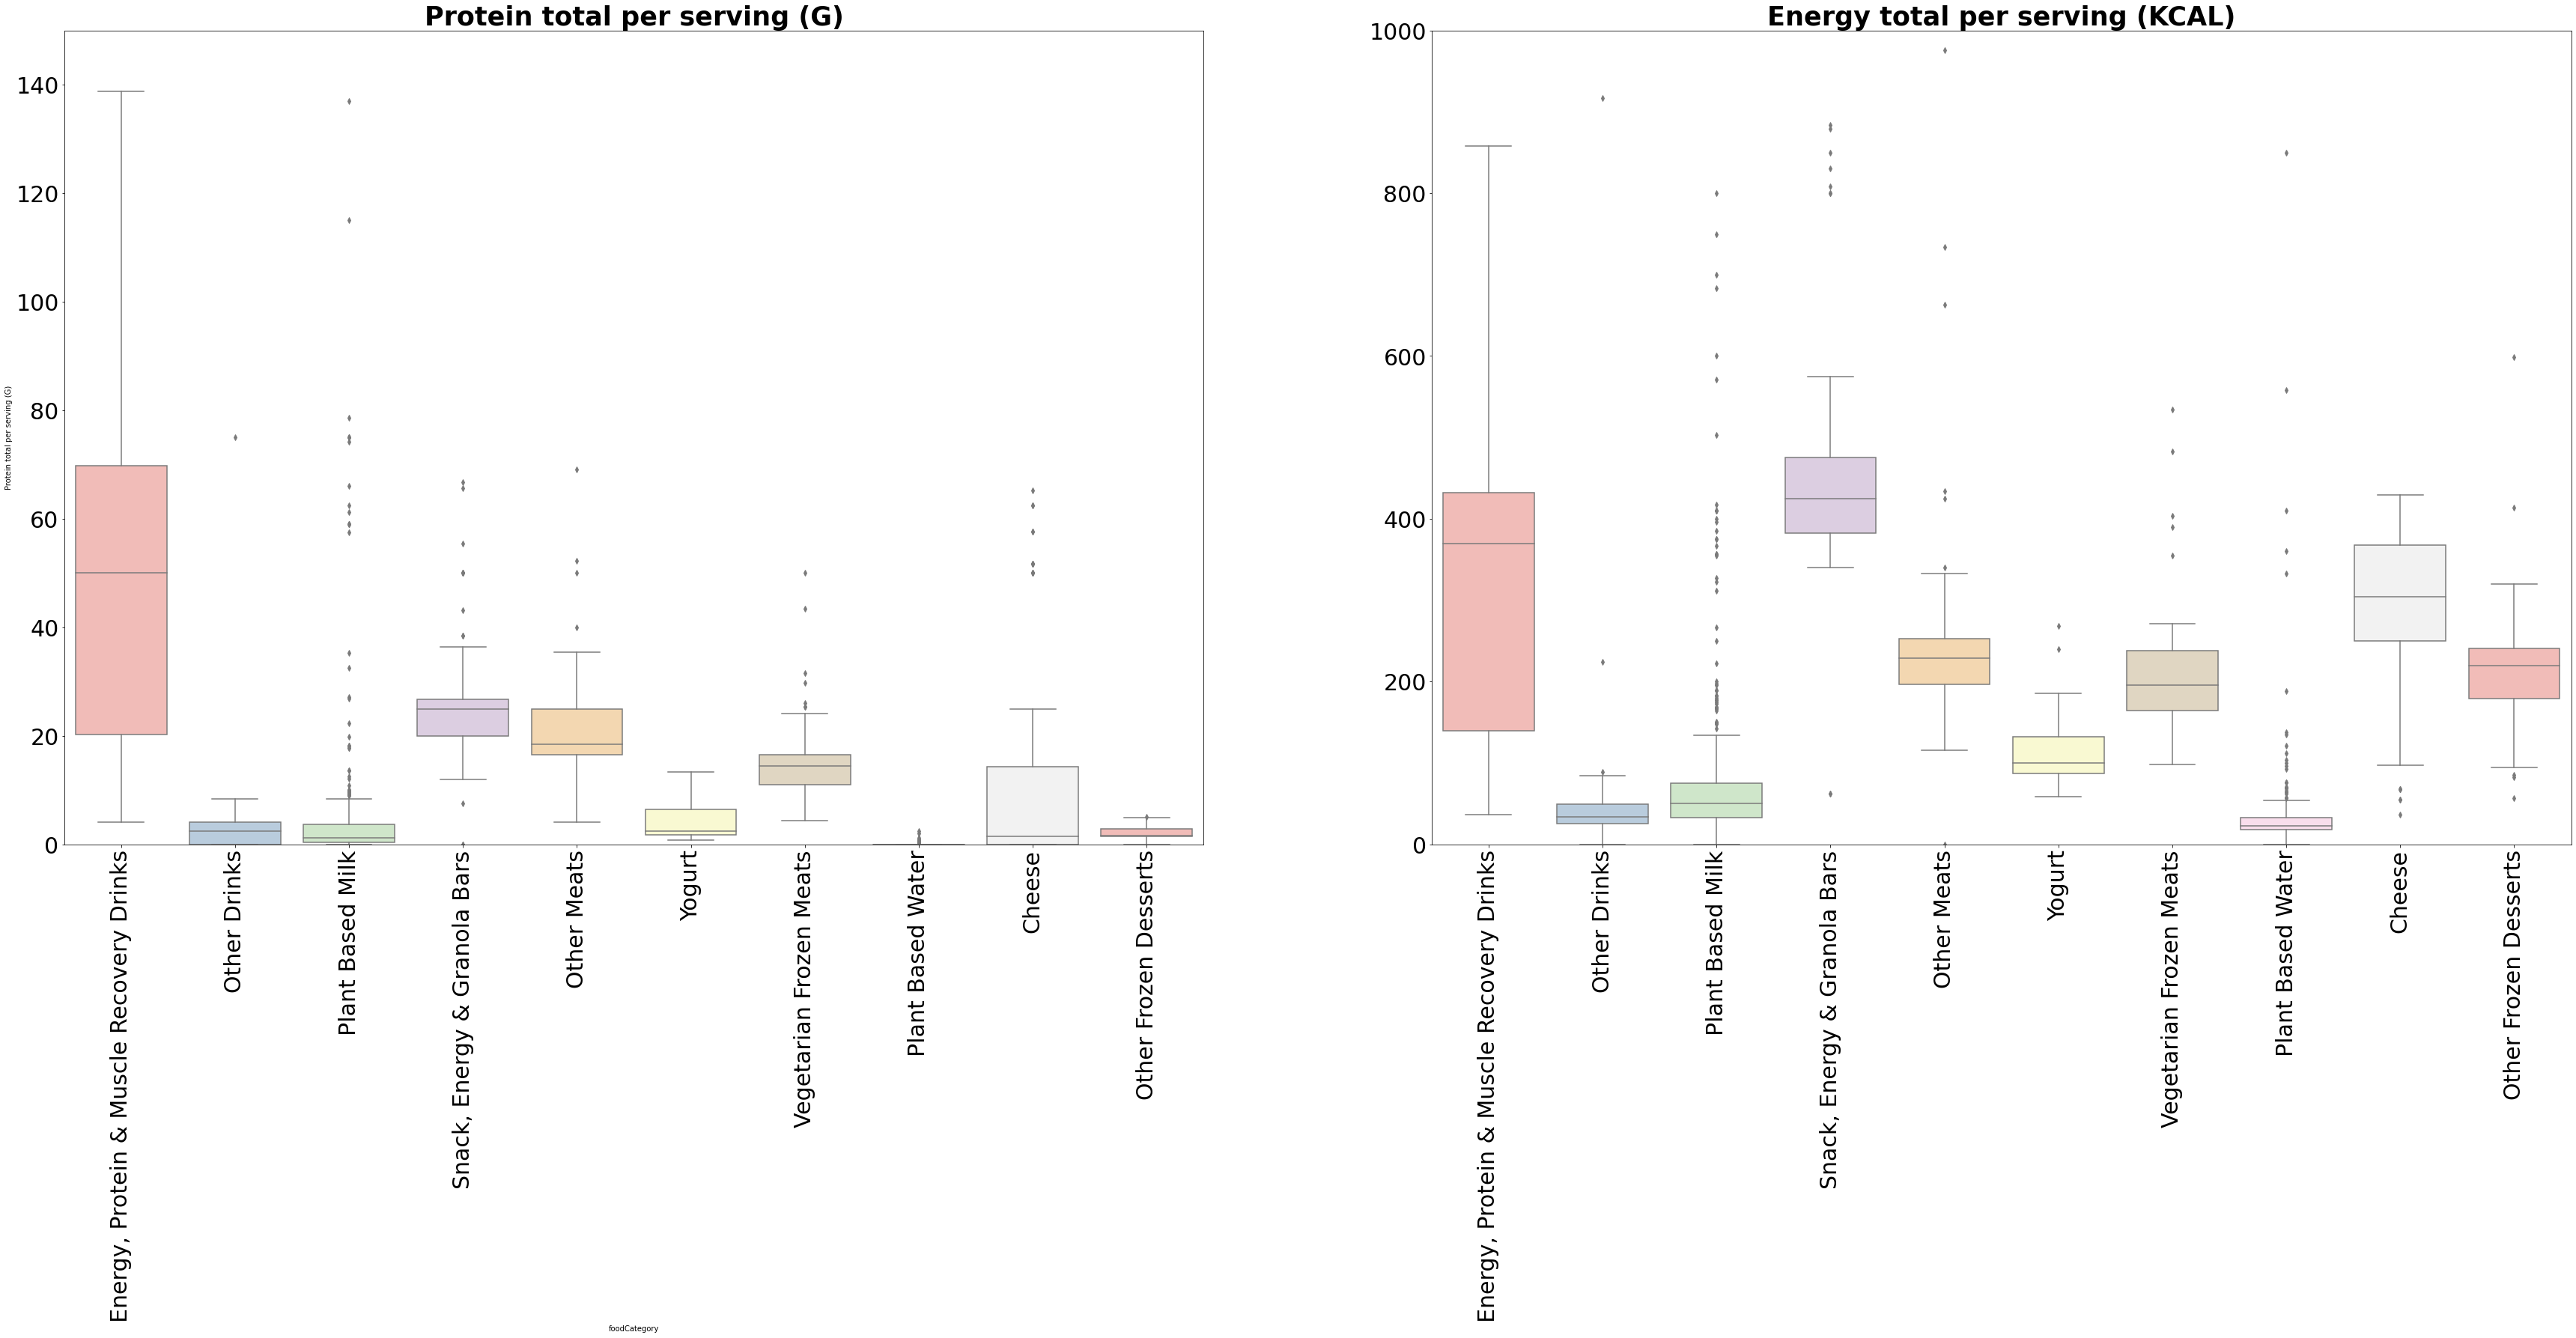

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(60,20))
ax1, ax2 = axs.ravel()

#plot 1
ax1.set_ylim(0,150)
ax1.tick_params(axis='x',labelrotation=90)
ax1.set(xlabel=None, ylabel=None)
ax1.set_title(nu_li[3], fontsize=35, fontweight='bold', loc='center');
protein = sns.boxplot(x='foodCategory', y=nu_li[3], data=for_plot, 
                      ax=axs[0], palette="Pastel1")
protein.tick_params(labelsize=30)

#plot 2
ax2.set_ylim(0,1000);
ax2.tick_params(axis='x',labelrotation=90)
energy = sns.boxplot(x='foodCategory', y=nu_li[4], data=for_plot, 
                     ax=axs[1], palette="Pastel1")
ax2.set(xlabel=None, ylabel=None)
energy.tick_params(labelsize=30)
ax2.set_title(nu_li[4], fontsize=35, fontweight='bold', loc='center');

<br>

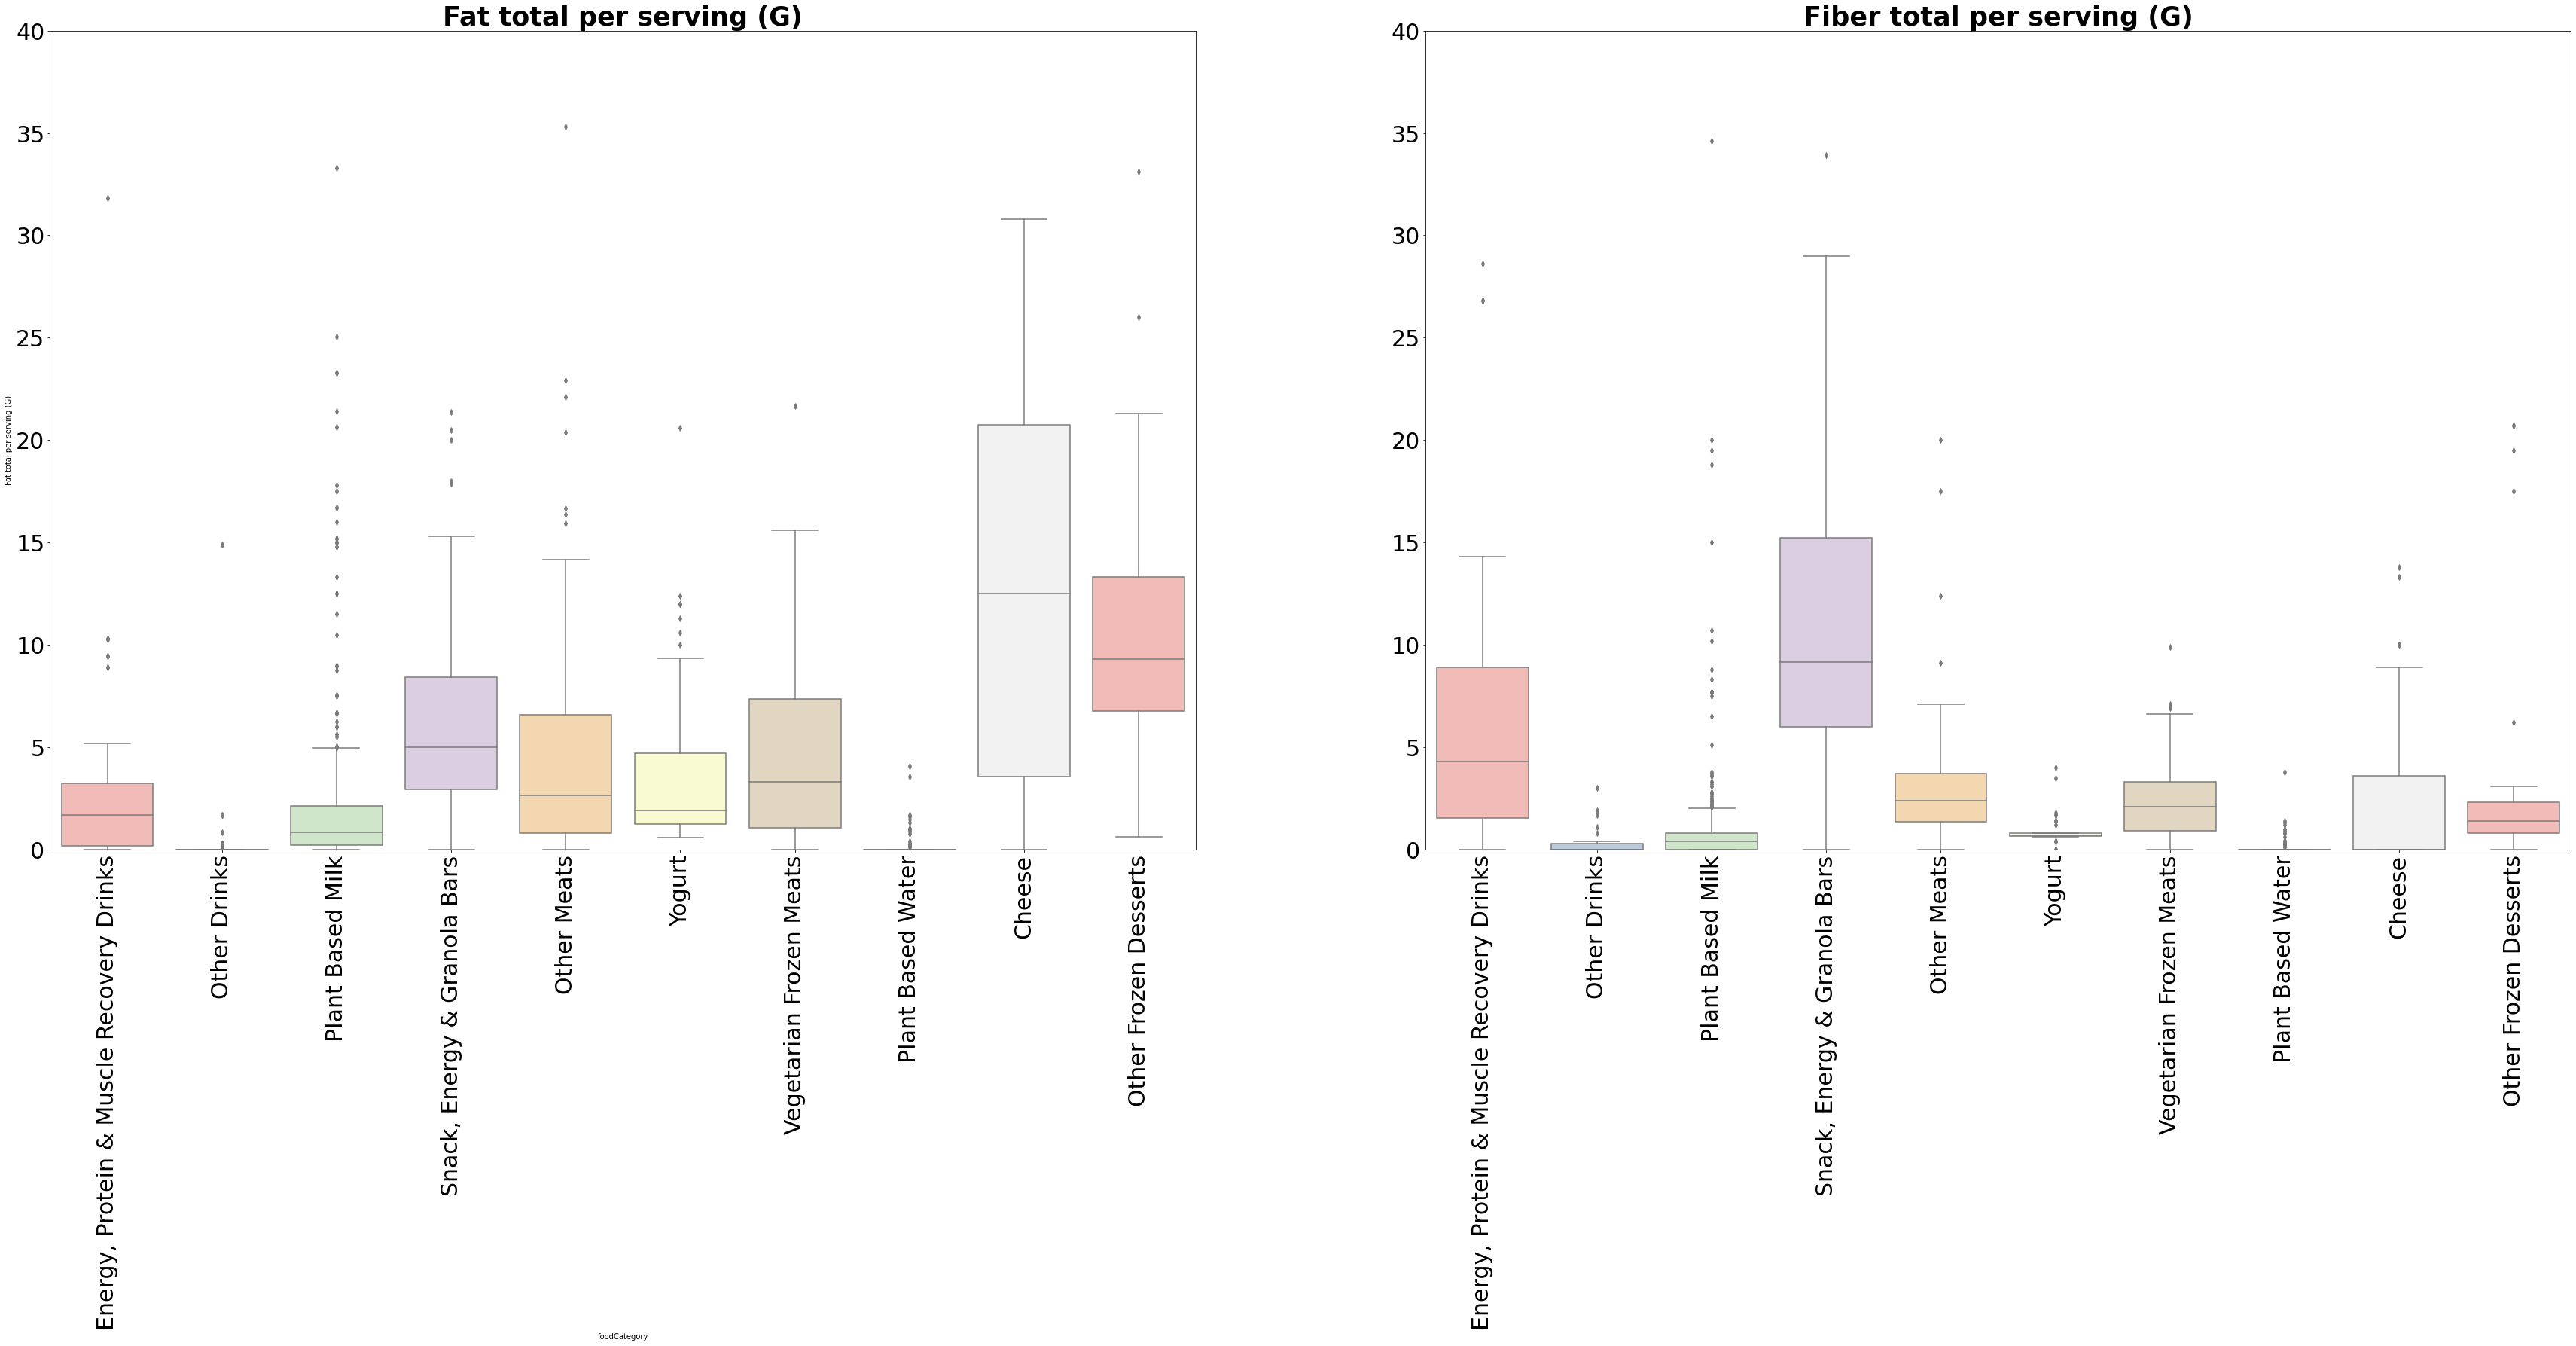

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(60,20))
ax1, ax2 = axs.ravel()

#plot 3
ax1.set_ylim(0,40)
ax1.tick_params(axis='x',labelrotation=90)
ax1.set(xlabel=None, ylabel=None)
ax1.set_title(nu_li[0], fontsize=35, fontweight='bold', loc='center');
fat = sns.boxplot(x='foodCategory', y=nu_li[0], data=for_plot, ax=axs[0], palette="Pastel1")
fat.tick_params(labelsize=30)

#plot 4
ax2.set_ylim(0,40);
ax2.tick_params(axis='x',labelrotation=90)
fiber = sns.boxplot(x='foodCategory', y=nu_li[1], data=for_plot, ax=axs[1], palette="Pastel1")
ax2.set(xlabel=None, ylabel=None)
fiber.tick_params(labelsize=30)
ax2.set_title(nu_li[1], fontsize=35, fontweight='bold', loc='center');

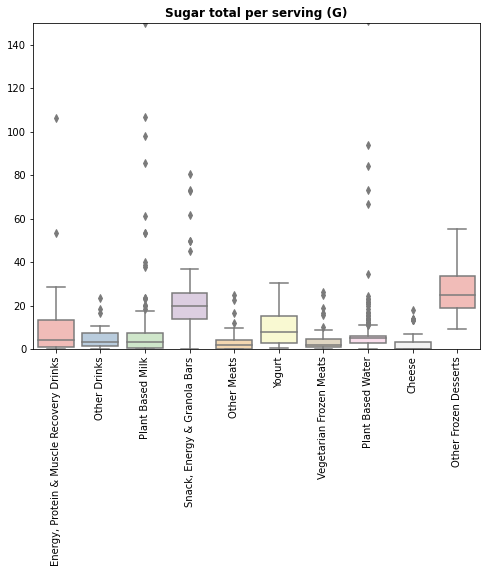

In [53]:
plt.figure(figsize=(8,6))
sugar = sns.boxplot(x='foodCategory', y=nu_li[2], data=for_plot, palette="Pastel1");
sugar.set(ylim=(0,150))
sugar.tick_params(axis='x',labelrotation=90)
sugar.set_title(nu_li[2], fontsize=12, fontweight='bold', loc='center')
sugar.set(xlabel=None, ylabel=None);

Isn't it dissapointin to see that the amount of protein and energy in **Energy, Protein & Muscle Recovery Drinks** is not always high? Also, the amount of fat in **Cheese** can be very different and a plant-based cheese doesn't necessarily mean less fat. 

# Conclusion

All in all, we can see that there are a wide range of plant-based food products in the market and there are surely more to come. The top ingredients contained by these products are less artificial than I thought they would be. The nutrients contained in them can vary greatly even within the same food category. This project serves as a good starting point to understand plant-based food products and a further comparison analysis between plant-based and regualr food items would be even more interesting.

# Learnings

In this course, not only did I learn about NoSQL databases theories, data modelling knowledge, key concepts in MongoDB, but I also got a better understanding on JSON format and APIs. I enjoy the freedom given in this project to choose any datasets of our own interest and do analysis as we want. This was a good opportunity for me to perform a ELT process. The PDF part was definitely more complicated than I thought! But I'm glad that I will now be able to present my work in nice PDFs in the future.